Importing Packages

In [134]:
import torch
torch.set_default_dtype(torch.double)
torch.set_default_device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.optim import Adam
from torch.optim import LBFGS
import torch.nn as nn
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from ipywidgets import widgets
from IPython.display import display

import plotly.express as px
import dash
from dash import Dash, dcc, html, Input, Output, State

Helper function to create a grid

In [135]:
def grid(x,y,z,nx,ny,nz,i=False):
    grid_arr = list()
    ex,ey,ez = x,y/2.0,z/2.0
    sx,sy,sz = 0,-ey,-ez
    if (nx == 1): sx = x
    if (ny == 1): sy = y
    if (nz == 1): sz = z
    if (i): sx,ex,sy,ey,sz,ez = 0.1*x,0.9*x,0.9*sy,0.9*ey,0.9*sz,0.9*ez
    xs = torch.linspace(sx,ex,nx)
    ys = torch.linspace(sy,ey,ny)
    zs = torch.linspace(sz,ez,nz)
    for x in xs:
        for y in ys:
            for z in zs:
                grid_arr.append((x.item(),y.item(),z.item()))
    grid_arr = torch.tensor(grid_arr)
    return grid_arr

Physical System to Model: 3D Deformation, Linear Isotropic

Training tensor within region of interest [10,1,1]

Solution: With Force (F), Area (A), Length (L), and Elastic Modulus (E), $\delta = \frac{\sigma L}{E}$

5% Deformation along x, -2.25% deformation along y and z.

In [136]:
# Range of x and y to be modelled
# 10, 10e-3...
x_range, x_int = 10, 30
y_range, y_int = 1, 3
z_range, z_int = 1, 3

body_grid = grid(x_range,y_range,z_range,x_int,y_int,z_int).requires_grad_(True)

phy_pos = grid(x_range,y_range,z_range,x_int,y_int,z_int,i=True).requires_grad_(True)

# Physical Parameters, E = Youngs Modulus (Pa), v = Poisson's ratio (Typically [-1,0.5]).
# Sclera
p = dict(E=1.2e6, v=0.45)
#Stiffness mat, 3D
C = [[1-p['v'], p['v'], p['v'], 0, 0, 0],
     [p['v'], 1-p['v'], p['v'], 0, 0, 0],
     [p['v'], p['v'], 1-p['v'], 0, 0, 0],
     [0, 0, 0, (1-2*p['v']), 0, 0],
     [0, 0, 0, 0, (1-2*p['v']), 0],
     [0, 0, 0, 0, 0, (1-2*p['v'])]]
C = torch.tensor(C)
C = C*p['E']/((1+p['v'])*(1-2*p['v']))

def_percentage = 5.0/100
s_xx = def_percentage*p['E']

#DBC, Position and Displacment.
# Fixing x disp = 0
DBC_pos = grid(0,y_range,z_range,1,y_int,z_int)
DBC_disp = torch.stack([DBC_pos[:,0]*1, DBC_pos[:,1]*-0.0225, DBC_pos[:,2]*-0.0225],dim=1)
DBC_pos, DBC_disp = DBC_pos.requires_grad_(True),DBC_disp.requires_grad_(True)
DBC = [DBC_pos,DBC_disp]

#NBC, Scalar Traction Force, Normal Vector, and Position.
T_hat = [[s_xx,0,0],
         [0,0,0],
         [0,0,0],
         [0,0,0],
         [0,0,0]]

n_hat = [(1.0,0,0),
         (0,-1.0,0),
         (0,1.0,0),
         (0,0,-1.0),
         (0,0,1.0)]

T_hat, n_hat = torch.tensor(T_hat),torch.tensor(n_hat)

T_pos = [grid(x_range,y_range,z_range,1,y_int,z_int).requires_grad_(True)]
T_pos.append(grid(x_range,-y_range/2.0,z_range,x_int,1,z_int).requires_grad_(True))
T_pos.append(grid(x_range,y_range/2.0,z_range,x_int,1,z_int).requires_grad_(True))
T_pos.append(grid(x_range,y_range,-z_range/2.0,x_int,y_int,1).requires_grad_(True))
T_pos.append(grid(x_range,y_range,z_range/2.0,x_int,y_int,1).requires_grad_(True))
NBC = [T_pos,n_hat,T_hat]

Plotting Model Prediction

In [137]:
def plot_comp(ax1,ax2,t=""):
    plot_input = body_grid
    pred = model(plot_input)
    
    loss= loss_fn(model)
    pred_plot = pred.cpu().detach().numpy() + plot_input.cpu().detach().numpy()

    plt.scatter(pred_plot[:,ax1].T,pred_plot[:,ax2].T,label='Deformed',marker='.')
    plt.xlabel('Position')
    plt.title("Deformation in "+t+f", Loss: {loss:.2E}, Epoch {epoch}")
    plt.show()
    plt.clf()

Plot Training Data

In [138]:
def plot_train(t=""):
    plt.plot(np.log10(prev_loss),c='tab:blue',label='Log Loss')
    plt.title(f"Log Loss over {len(prev_loss)} Calls"+t)
    plt.xlabel("Calls")
    plt.ylabel("Log Loss")
    plt.legend()
    plt.show()
    plt.clf()

    plt.plot(np.log10(prev_phy),label='Log Physics Loss',c='tab:green')
    plt.title(f"Physics Loss over {len(prev_phy)} Calls"+t)
    plt.xlabel("Loss Computations")
    plt.ylabel("Log Physics Loss")
    plt.legend()
    plt.show()
    plt.clf()

    plt.plot(np.log10(prev_NBC),label='Log NBC Loss',c='tab:orange')
    plt.title(f"NBC Loss over {len(prev_NBC)} Calls"+t)
    plt.xlabel("Loss Computations")
    plt.ylabel("Log NBC Loss")
    plt.legend()
    plt.show()
    plt.clf()

    plt.plot(np.log10(prev_DBC),label='Log DBC Loss',c='tab:red')
    plt.title(f"DBC Loss over {len(prev_DBC)} Calls"+t)
    plt.xlabel("Loss Computations")
    plt.ylabel("Log DBC Loss")
    plt.legend()
    plt.show()
    plt.clf()

    for i in range(3):
        plt.plot(np.log10(prev_divS[i]),c='tab:red')
        plt.title(f"Div of Stress {i}")
        plt.show()
        plt.clf()

    for i in range(5):
        plt.plot(np.log10(prev_sigmaS[i]),c='tab:red')
        plt.title(f"NBCs {i}")
        plt.show()
        plt.clf()

    for i in range(3):
        plt.plot(np.log10(prev_dispS[i]),c='tab:red')
        plt.title(f"DBCs {i}")
        plt.show()
        plt.clf()

Creating the Model

In [139]:
# i_num nodes, i_len nodes per layer and Tanh activation fn, wide and shallow (64x4)
i_num = 2
i_len = 32
#params to take and approximate
params_in = 3
params_out = 3

# fn to create model
def pinn(input_size, output_size, num_layers, nodes_per_layer, activation):
    layers = []
    
    # Input layer
    layers.append(nn.Linear(input_size, nodes_per_layer))
    
    # Hidden layers
    for layer in range(num_layers):
        layers.append(nn.Linear(nodes_per_layer, nodes_per_layer))
        if layer == 0 and activation==Siren:
            layers.append(activation(l=0))
        else:
            layers.append(activation())
    
    # Output layer
    layers.append(nn.Linear(nodes_per_layer, output_size))
    
    return nn.Sequential(*layers)

# custom trainable Tanh activation fn
class TTanh(nn.Module):
    def __init__(self, features=i_len):
        super().__init__()
        self.features = features
        self.a = nn.Parameter(torch.randn(1, features))
        
    def forward(self, x):
        return torch.tanh(self.a * x)

#custom SIREN activation fn
class Siren(nn.Module):
    def __init__(self, features=i_len, l=1):
        super(Siren, self).__init__()
        self.features = features
        # Learnable parameters for the phase and bias
        if l: w = 1 
        else: w = 30
        n = torch.sqrt(torch.tensor(6.0/features))
        self.a_weight = nn.Parameter((torch.rand(1, features) *2*n - n)*w)
        self.a_bias = nn.Parameter(torch.randn(1, features))

    def forward(self, x):
        # Apply the periodic activation function
        return torch.sin( self.a_weight*x + self.a_bias)

#torch.nn.Tanh or TTanh or Siren
model = pinn(params_in, params_out, i_num, i_len, TTanh)

Loss Function has the following components:

Physics Loss:

$\mathcal{L}_{Phy} = \frac{1}{N}\sum[\frac{\partial \sigma_{ij}}{\partial x_{j}}]^2$

NBC Loss:

$\mathcal{L}_{NBC} = \frac{1}{N}\sum[n.\sigma - \hat{T}]^2$

DBC Loss:

$\mathcal{L}_{DBC} = \frac{1}{N}\sum[u-\hat{u}]^2$

In [140]:
def Stress(model,input):
    # Strain from displacement field
    pred = model(input)

    dux = torch.autograd.grad(pred[:,0], input, torch.ones_like(pred[:,0]), create_graph=True)[0]
    duy = torch.autograd.grad(pred[:,1], input, torch.ones_like(pred[:,1]), create_graph=True)[0]
    duz = torch.autograd.grad(pred[:,2], input, torch.ones_like(pred[:,2]), create_graph=True)[0]
    
    duxdx = dux[:,0]
    duxdy = dux[:,1]
    duxdz = dux[:,2]

    duydx = duy[:,0]
    duydy = duy[:,1]
    duydz = duy[:,2]

    duzdx = duz[:,0]
    duzdy = duz[:,1]
    duzdz = duz[:,2]

    epsilon = torch.stack((duxdx, duydy, duzdz, 0.5*(duxdy + duydx), 0.5*(duxdz + duzdx), 0.5*(duydz + duzdy)))
    
    # Stress from Strain and Constitutive matrix
    sigma_6xn = torch.matmul(C,epsilon)

    return sigma_6xn[0,:],sigma_6xn[1,:],sigma_6xn[2,:],sigma_6xn[3,:],sigma_6xn[4,:],sigma_6xn[5,:]

In [141]:
def loss_fn(model):
    # model: model
    prev_disp.clear()
    prev_sigma.clear()
    prev_div.clear()

    # Calulate loss from DBC
    DBC_loss = ((model(DBC[0])-DBC[1])**2).mean()

    #Calculating NBC Loss
    NBC_loss = 0.0
    for i in range(len(NBC[0])):
        sxx_NBC,syy_NBC,szz_NBC,sxy_NBC,sxz_NBC,syz_NBC = Stress(model,NBC[0][i])

        sigma_1x3_x_NBC = torch.stack((sxx_NBC,sxy_NBC,sxz_NBC), dim=1)
        sigma_1x3_y_NBC = torch.stack((sxy_NBC,syy_NBC,syz_NBC), dim=1)
        sigma_1x3_z_NBC = torch.stack((sxz_NBC,syz_NBC,szz_NBC), dim=1)
        sigma_3x3_NBC = torch.stack((sigma_1x3_x_NBC, sigma_1x3_y_NBC, sigma_1x3_z_NBC), dim=1)

        #NBC Loss
        T = torch.matmul(sigma_3x3_NBC,NBC[1][i])
        NBC_loss += ((T - NBC[2][i])**2).mean()

        prev_sigma.append(sigma_3x3_NBC.detach().clone())
        prev_sigmaS[i].append(((T - NBC[2][i])**2).mean().item())


    #Physics Loss
    
    #Stress
    sxx_phy,syy_phy,szz_phy,sxy_phy,sxz_phy,syz_phy = Stress(model,phy_pos)

    #Divergence of Stress
    
    dsxx = torch.autograd.grad(sxx_phy, phy_pos, torch.ones_like(sxx_phy), create_graph=True)[0]
    dsyy = torch.autograd.grad(syy_phy, phy_pos, torch.ones_like(syy_phy), create_graph=True)[0]
    dszz = torch.autograd.grad(szz_phy, phy_pos, torch.ones_like(szz_phy), create_graph=True)[0]

    dsxy = torch.autograd.grad(sxy_phy, phy_pos, torch.ones_like(sxy_phy), create_graph=True)[0]
    dsxz = torch.autograd.grad(sxz_phy, phy_pos, torch.ones_like(sxz_phy), create_graph=True)[0]
    dsyz = torch.autograd.grad(syz_phy, phy_pos, torch.ones_like(syz_phy), create_graph=True)[0]

    dsxxdx = dsxx[:,0]
    dsyydy = dsyy[:,1]
    dszzdz = dszz[:,2]

    dsxydx = dsxy[:,0]
    dsyxdy = dsxy[:,1]

    dsxzdx = dsxz[:,0]
    dszxdz = dsxx[:,2]

    dsyzdy = dsyz[:,1]
    dszydz = dsyz[:,2]

    div_stress = torch.stack((dsxxdx + dsyxdy + dszxdz,
                              dsxydx + dsyydy + dszydz,
                              dsxzdx + dsyzdy + dszzdz), dim=1)
    

    phy_loss = ((div_stress)**2).mean()

    loss = DBC_loss + NBC_loss + phy_loss
    

    prev_disp.append(model(DBC[0]).detach().clone())
    
    prev_dispS[0].append(((model(DBC[0])[:,0]-DBC[1][:,0])**2).mean().item())
    prev_dispS[1].append(((model(DBC[0])[:,1]-DBC[1][:,1])**2).mean().item())
    prev_dispS[2].append(((model(DBC[0])[:,2]-DBC[1][:,2])**2).mean().item())

    prev_divS[0].append(((div_stress)**2)[:,0].mean().item())
    prev_divS[1].append(((div_stress)**2)[:,1].mean().item())
    prev_divS[2].append(((div_stress)**2)[:,2].mean().item())

    prev_div.append(div_stress.detach().clone())
    
    prev_loss.append(loss.item())
    prev_NBC.append(NBC_loss.item())
    prev_DBC.append(DBC_loss.item())
    prev_phy.append(phy_loss.item())

    return loss

Checkpoint During Training

In [142]:
best_model_adam = {'epoch':-1}
best_model_LBFGS = {'epoch':-1}
best_model = {'epoch':-1}
final_model_adam = {'epoch':-1}
final_model_LBGFS = {'epoch':-1}

def checkpoint(best_model):
    if (best_model['epoch'] == -1) or (prev_loss[-1] < best_model['loss']):
        best_model = {
            'epoch': epoch,
            'model_state_dict': copy.deepcopy(model.state_dict()),
            'optimizer_state_dict': copy.deepcopy(optim.state_dict()),
            'loss': prev_loss[-1],
            'model_params':[params_in, params_out, i_num, i_len],
        'p_sigma': prev_sigma,
        'p_div': prev_div,
        'p_disp': prev_disp
                    }
    return best_model

def final(model):
    model = {
        'epoch': epoch,
        'model_state_dict': copy.deepcopy(model.state_dict()),
        'optimizer_state_dict': copy.deepcopy(optim.state_dict()),
        'loss': prev_loss,
        'model_params':[params_in, params_out, i_num, i_len],
        'p_sigma': prev_sigma,
        'p_div': prev_div,
        'p_disp': prev_disp
                }
    return model

Closure Fn for Optimisers

In [143]:
def closure():
    loss = loss_fn(model)
    optim.zero_grad()
    loss.backward()
    return loss

Training the model

Finished epoch 0, latest loss 1.16E+05
Finished epoch 100, latest loss 1.42E+09
Finished epoch 200, latest loss 1.31E+09
Finished epoch 300, latest loss 1.69E+10
Finished epoch 400, latest loss 1.41E+09


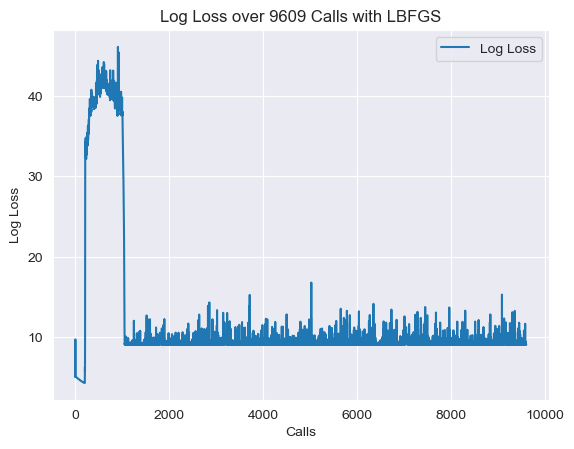

C:\Users\roshe\AppData\Local\Temp\ipykernel_15416\4291369786.py:10: RuntimeWarning:

divide by zero encountered in log10



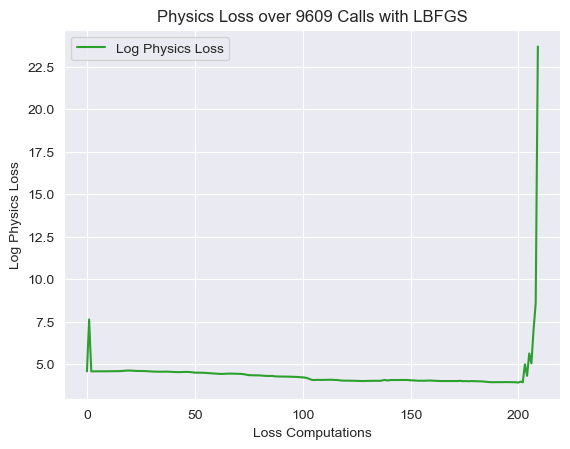

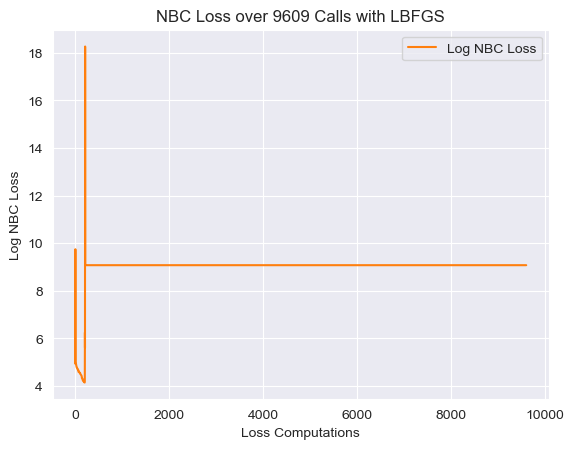

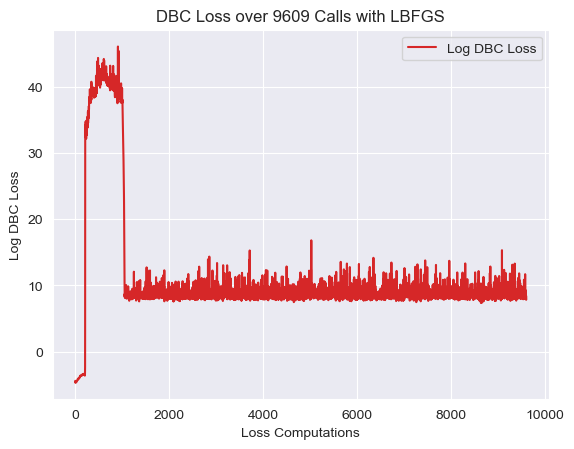

C:\Users\roshe\AppData\Local\Temp\ipykernel_15416\4291369786.py:35: RuntimeWarning:

divide by zero encountered in log10



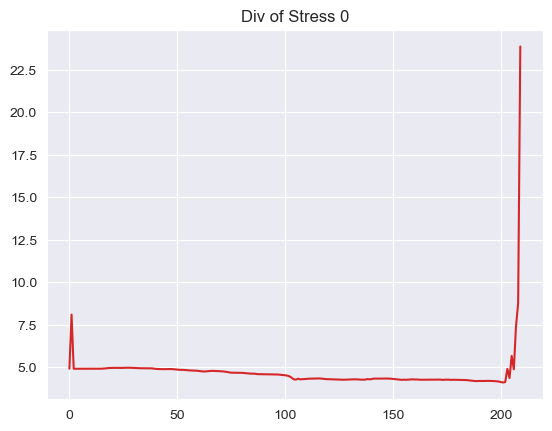

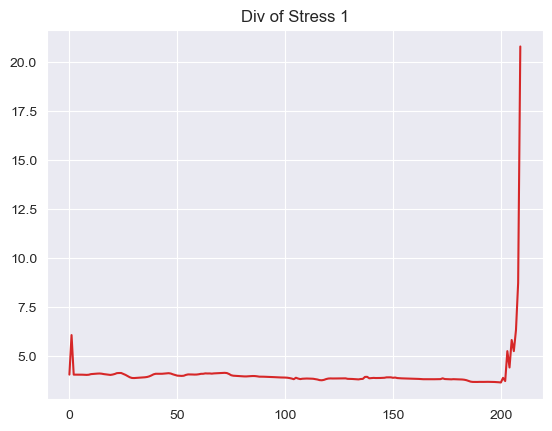

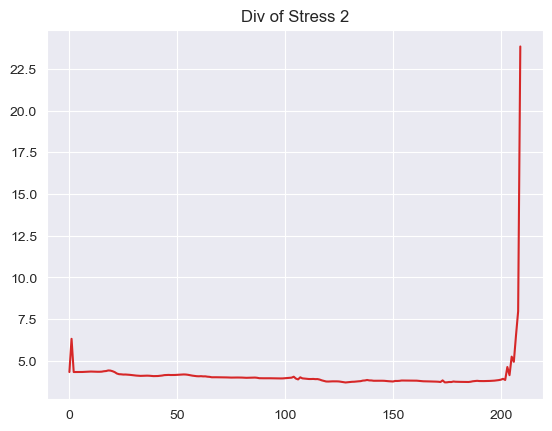

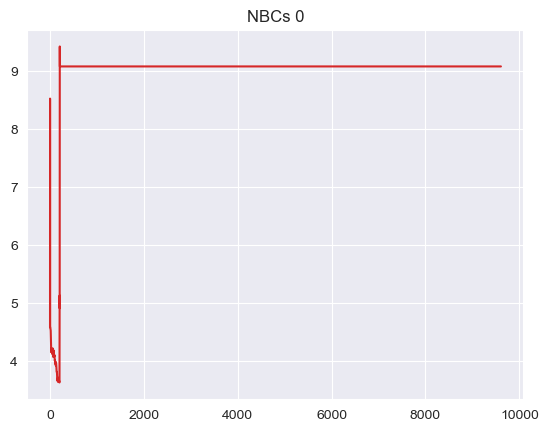

C:\Users\roshe\AppData\Local\Temp\ipykernel_15416\4291369786.py:41: RuntimeWarning:

divide by zero encountered in log10



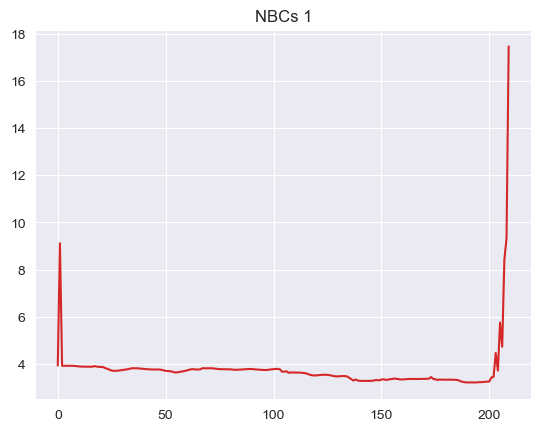

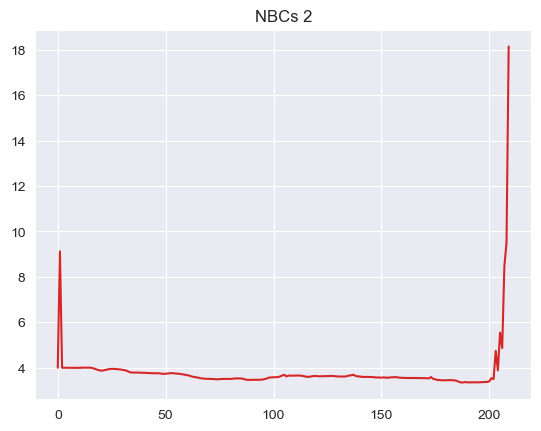

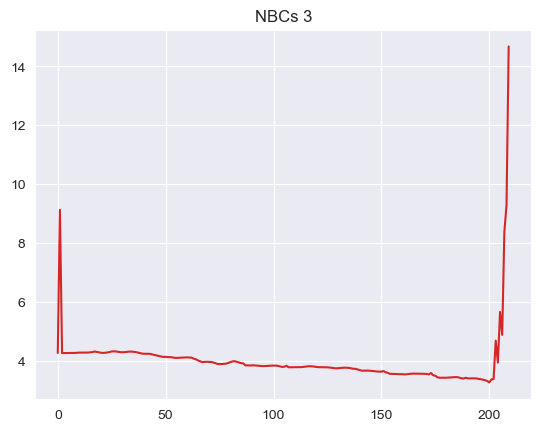

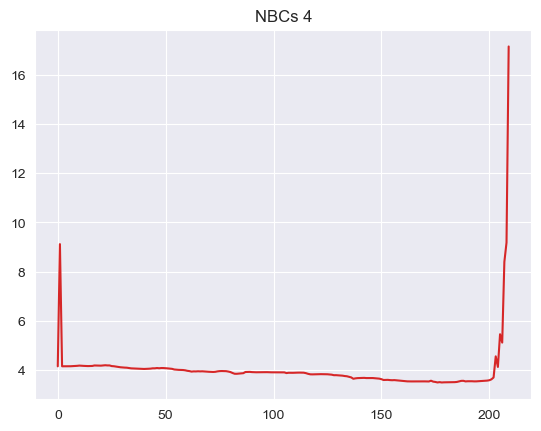

C:\Users\roshe\AppData\Local\Temp\ipykernel_15416\4291369786.py:47: RuntimeWarning:

divide by zero encountered in log10



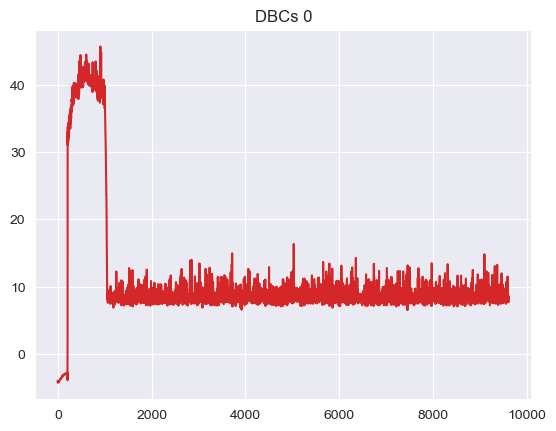

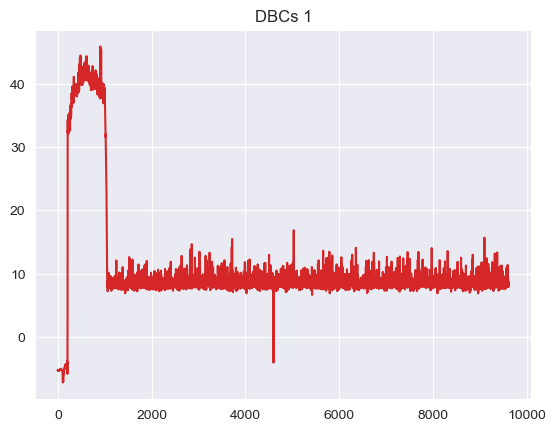

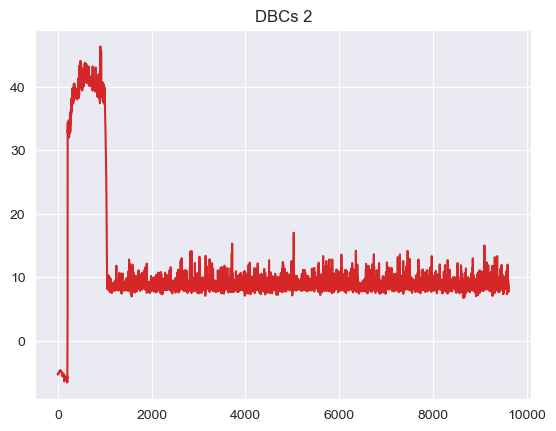

(0,)


<Figure size 640x480 with 0 Axes>

In [149]:
# train
n_epochs = (0,500)
w_update = 1
epochs = 1
prev_loss, prev_phy, prev_NBC, prev_DBC = list(),list(),list(),list()
prev_div, prev_sigma, prev_disp, prev_sigmaS, prev_dispS, prev_divS = list(),list(),list(), [list(),list(),list(),list(),list()], [list(),list(),list()], [list(),list(),list()]
# variable to store training status and optimiser currently active
training = True
current_optim = "N"

while (training):
    if (n_epochs[0]>0):
        # start with Adam optimizer or load state
        if (current_optim != "A"): optim = Adam(model.parameters())
        current_optim = "A"

        for epoch in range(n_epochs[0]):
            
            optim.step(closure)
            best_model_adam = checkpoint(best_model_adam)
            best_model = checkpoint(best_model)

            if not (epoch%1000): print(f'Finished epoch {epoch}, latest loss {prev_loss[-1]:.2E}')
        
        final_model_adam = final(model)
        plot_train(" with Adam")
        epochs += n_epochs[0]

    if (n_epochs[1]>0):
        # continue with LBFGS or load state
        if (current_optim != "L"): optim = LBFGS(model.parameters())
        current_optim = "L"

        for epoch in range(n_epochs[1]):
            optim.step(closure)

            # reset if loss becomes NAN
            if np.isnan(prev_loss[-1]):
                optim = LBFGS(model.parameters())
                model.load_state_dict(best_model_LBFGS['model_state_dict'])
                optim.load_state_dict(best_model_LBFGS['optimizer_state_dict'])

            best_model_LBFGS = checkpoint(best_model_LBFGS)
            best_model = checkpoint(best_model)

            if not (epoch%100): print(f'Finished epoch {epoch}, latest loss {prev_loss[-1]:.2E}')
        
        final_model_LBGFS = final(model)
        plot_train(" with LBFGS")
        epochs += n_epochs[1]


    # User determines if training should continue
    user_input = input("Enter epochs to continue training (Adam LBGFS) or 0 to stop:")
    try:
        n_epochs = tuple(int(item) for item in user_input.split())
        print(n_epochs)
    except:
        print("Error")
        n_epochs = (0,0)
    if len(n_epochs) != 2: training = False

Plotting best model

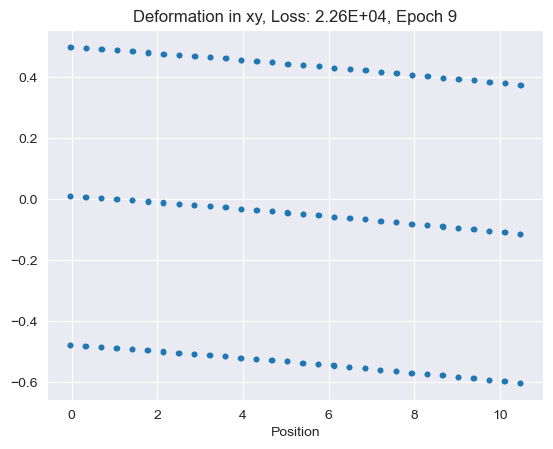

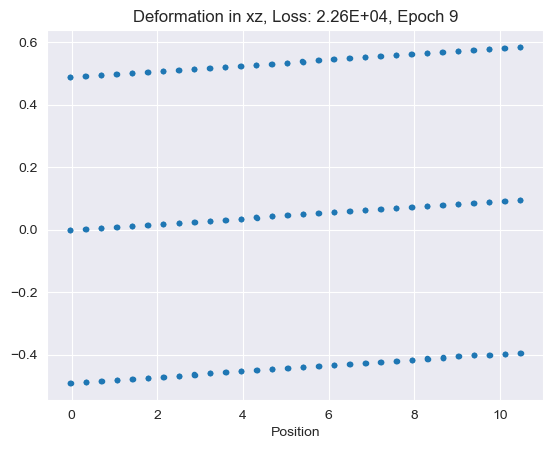

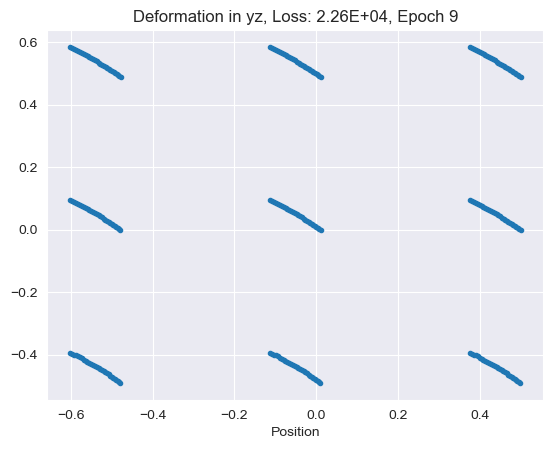

[tensor([[-0.0366,  0.0211,  0.0105],
        [-0.0413,  0.0215, -0.0008],
        [-0.0457,  0.0219, -0.0120],
        [-0.0319,  0.0099,  0.0101],
        [-0.0365,  0.0104, -0.0012],
        [-0.0409,  0.0108, -0.0124],
        [-0.0269, -0.0013,  0.0097],
        [-0.0316, -0.0009, -0.0016],
        [-0.0361, -0.0005, -0.0128]], device='cuda:0')]
[tensor([[[ 5.9863e+04,  6.9998e+01,  4.7605e+01],
         [ 6.9998e+01, -2.9685e+01, -1.5949e+01],
         [ 4.7605e+01, -1.5949e+01, -3.7881e+01]],

        [[ 6.0008e+04,  3.0592e+01, -1.7298e+01],
         [ 3.0592e+01, -2.8846e+01, -1.4173e+01],
         [-1.7298e+01, -1.4173e+01, -7.7397e+01]],

        [[ 6.0124e+04, -7.8878e+00, -8.6816e+01],
         [-7.8878e+00, -1.8822e+01, -1.1963e+01],
         [-8.6816e+01, -1.1963e+01, -9.2044e+01]],

        [[ 5.9893e+04,  3.4058e+01,  4.1040e+01],
         [ 3.4058e+01, -2.5125e+01,  2.2854e+01],
         [ 4.1040e+01,  2.2854e+01, -5.6768e+01]],

        [[ 6.0004e+04, -8.0165e+00, -2

<Figure size 640x480 with 0 Axes>

In [150]:
model.load_state_dict(best_model['model_state_dict'])
optim.load_state_dict(best_model['optimizer_state_dict'])
epoch = best_model['epoch']
loss = best_model['loss']
model.eval()

plot_comp(0,1,'xy')
plot_comp(0,2,'xz')
plot_comp(1,2,'yz')

print(prev_disp)
print(prev_sigma)
print(prev_div)



Saving Best Model

In [146]:
#PATH = f"3D_Isotropic_Beam_Model_{loss:.2E}_{epoch}.tar"
#torch.save(best_model, PATH)

Load Model

In [147]:
# PATH = "3D_Isotropic_Beam_Model_4.55E+05_9962.tar"

# prevpoint = torch.load(PATH)
# model.load_state_dict(prevpoint['model_state_dict'])
# optim.load_state_dict(prevpoint['optimizer_state_dict'])
# epoch = prevpoint['epoch']
# loss = prevpoint['loss']
# model = model
# model.eval()
# model.train()

Ploty and Dash Animaton

In [151]:
plotting = body_grid
max_disp, max_x, max_y, max_z, min_x, min_y, min_z = 0,0,0,0,x_range,y_range,z_range

# obtaining plot data
model_pred = list()
for i in range(len(plotting)):
    #x,y,z,dx,dy,dz
    pred = model(plotting[i])
    model_pred.append([plotting[i][0].item(), plotting[i][1].item(), plotting[i][2].item(), pred[:,0].item(), pred[:,1].item(), pred[:,2].item()])
    if (np.sqrt(pred[:,0].item()**2 + pred[:,1].item()**2 + pred[:,2].item()**2) > max_disp): max_disp = np.sqrt(pred[:,0].item()**2 + pred[:,1].item()**2 + pred[:,2].item()**2)
    if (pred[:,0].item() > max_x): max_x = pred[:,0].item()
    if (pred[:,1].item() > max_y): max_y = pred[:,1].item()
    if (pred[:,2].item() > max_z): max_z = pred[:,2].item()
    if (pred[:,0].item() < min_x): min_x = pred[:,0].item()
    if (pred[:,1].item() < min_y): min_y = pred[:,1].item()
    if (pred[:,2].item() < min_z): min_z = pred[:,2].item()
model_pred = np.array(model_pred)

# Theoretical sol
print("Sol for Def")
print(f"x = {def_percentage*100:.2E}%")
print(f"y = {def_percentage*100*-p['v']:.2E}%")
print(f"z = {(def_percentage*100*-p['v']):.2E}%")

# max def data
print("Max Def Pred")
print(f"x = {(max_x - min_x):.2E}, {((max_x - min_x)/x_range*100):.2E}%")
print(f"y = {(max_y - min_y):.2E}, {((max_y - min_y)/y_range*100):.2E}%")
print(f"z = {(max_z - min_z):.2E}, {((max_z - min_z)/z_range*100):.2E}%")

# DBC disp data
DBC_diff = (model(DBC[0])-DBC[1])**2
print("Sum of disp diff at fixed points:")
print(f"x : {DBC_diff.sum(dim=0)[0].item():.2E}, {DBC_diff.sum(dim=0)[0].item()/x_range*100:.2E}%")
print(f"y : {DBC_diff.sum(dim=0)[1].item():.2E}, {DBC_diff.sum(dim=0)[1].item()/y_range*100:.2E}%")
print(f"z : {DBC_diff.sum(dim=0)[2].item():.2E}, {DBC_diff.sum(dim=0)[2].item()/z_range*100:.2E}%")

#setting limits
init = model_pred[:,0:3]
disp = model_pred[:,0:3] + model_pred[:,3:]
buffer = 0.4

init_scatter = go.Scatter3d(
    x=init[:, 0],
    y=init[:, 1],
    z=init[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        colorscale='RdYlGn_r',
        color=np.zeros(len(model_pred[:, 0])),
        cmin=0,
        cmax=1,
        colorbar=dict(title='Normalized Displacement'),
    )
)

# Create init scatter
fig = go.Figure(data=[init_scatter])

# Create a Dash app
app = dash.Dash(__name__)

# Define the app layout
app.layout = html.Div([
    html.H1('Displacement Animation', style={'color': 'white'}),
    
    dcc.Graph(id='scatter-plot', figure=fig),
    
    dcc.Slider(
        id="frame-slider",
        min=0,
        max=100,
        step=0.1,
        value=0,
        marks={i: str(i) for i in range(0, 101, 10)},
        tooltip={"placement": "bottom"},
        updatemode='drag'
    )
])

# Callback to update the scatter plot
@app.callback(
    Output('scatter-plot', 'figure'),
    [Input('frame-slider', 'value')]
)

def update_scatter_plot(frame):
    # Update only the color data of the scatter plot
    fig.data[0].x = model_pred[:, 0] + frame * model_pred[:, 3] / 100
    fig.data[0].y =model_pred[:, 1] + frame * model_pred[:, 4] / 100
    fig.data[0].z =model_pred[:, 2] + frame * model_pred[:, 5] / 100
    fig.data[0].marker.color = np.sqrt(model_pred[:, 3]**2 + model_pred[:, 4]**2 + model_pred[:, 5]**2) * frame / max_disp / 100
    fig.update_layout(
        scene=dict(
            xaxis=dict(range=[np.min(np.vstack([init, disp])) - buffer, np.max(np.vstack([init, disp])) + buffer]),
            yaxis=dict(range=[np.min(np.vstack([init, disp])) - buffer, np.max(np.vstack([init, disp])) + buffer]),
            zaxis=dict(range=[np.min(np.vstack([init, disp])) - buffer, np.max(np.vstack([init, disp])) + buffer]),
        ),
        autosize=False,
        width=800,
        height=600,
        uirevision='locked',
    )
    
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)

Sol for Def
x = 5.00E+00%
y = -2.25E+00%
z = -2.25E+00%
Max Def Pred
x = 5.31E-01, 5.31E+00%
y = 1.47E-01, 1.47E+01%
z = 1.20E-01, 1.20E+01%
Sum of disp diff at fixed points:
x : 1.22E-02, 1.22E-01%
y : 9.59E-04, 9.59E-02%
z : 1.30E-05, 1.30E-03%
